In [1]:
!pip install matplotlib seaborn


[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from pyspark.sql import SparkSession, functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from src.utils.spark_builder import get_spark_session

spark = get_spark_session("Jupyter Test")
print("!! SparkSession ÏÉùÏÑ± ÏôÑÎ£å!")


25/09/17 03:35:26 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


!! SparkSession ÏÉùÏÑ± ÏôÑÎ£å!


In [4]:
# Silver Îç∞Ïù¥ÌÑ∞ Î°úÎìú
joined_path = "s3a://warehouse/silver/gdelt_events_detailed"
final_silver_df = spark.read.format("delta").load(joined_path)

print("‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å")
# print(f"Ï¥ù Î†àÏΩîÎìú Ïàò: {final_silver_df.count():,}")
print(f"Ïª¨Îüº Ïàò: {len(final_silver_df.columns)}")

25/09/17 03:35:43 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


‚úÖ Îç∞Ïù¥ÌÑ∞ Î°úÎìú ÏôÑÎ£å
Ïª¨Îüº Ïàò: 85


In [5]:
# Ï†ÑÏ≤¥ Ïª¨Îüº Ïù¥Î¶Ñ Ï∂úÎ†•
print("Ï†ÑÏ≤¥ Ïª¨Îüº Î™©Î°ù:")

# Ïä§ÌÇ§Îßà(ÌÉÄÏûÖ Ìè¨Ìï®Ìï¥ÏÑú Î≥¥Í∏∞)
final_silver_df.printSchema()

# ÏÉòÌîå Îç∞Ïù¥ÌÑ∞ Î≥¥Í∏∞ (Î¨∏ÏûêÏó¥ ÏûòÎ¶¨ÏßÄ ÏïäÍ≤å)
final_silver_df.show(3, truncate=False)

# ÏÑ∏Î°úÎ°ú Ìïú ÌñâÎßå ÏûêÏÑ∏Ìûà Î≥¥Í∏∞
final_silver_df.show(1, vertical=True)


Ï†ÑÏ≤¥ Ïª¨Îüº Î™©Î°ù:
root
 |-- global_event_id: long (nullable = true)
 |-- event_date: date (nullable = true)
 |-- actor1_code: string (nullable = true)
 |-- actor1_name: string (nullable = true)
 |-- actor1_country_code: string (nullable = true)
 |-- actor1_known_group_code: string (nullable = true)
 |-- actor1_ethnic_code: string (nullable = true)
 |-- actor1_religion1_code: string (nullable = true)
 |-- actor1_religion2_code: string (nullable = true)
 |-- actor1_type1_code: string (nullable = true)
 |-- actor1_type2_code: string (nullable = true)
 |-- actor1_type3_code: string (nullable = true)
 |-- actor2_code: string (nullable = true)
 |-- actor2_name: string (nullable = true)
 |-- actor2_country_code: string (nullable = true)
 |-- actor2_known_group_code: string (nullable = true)
 |-- actor2_ethnic_code: string (nullable = true)
 |-- actor2_religion1_code: string (nullable = true)
 |-- actor2_religion2_code: string (nullable = true)
 |-- actor2_type1_code: string (nullable = tr

25/09/17 03:35:59 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---------------+----------+------------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+-----------------+---------------+-----------------------------------+-----------------------+--------------------+--------------------+--------------+---------------+---------------------+-------------------+------------------------------------------------------+---------------+-----------------+------------+-------------------+-----------------------------------------------------+-----------+------------------+------------------+------------------+-----------+----------+--

null Í∞í

In [6]:
final_silver_df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in final_silver_df.columns]).show()

+---------------+----------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-----------+-----------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+-----------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+--------+---------------+-------------------+-----------------------+--------------------+--------------------+--------------+---------------+---------------------+----------+----------+---------------+-----------------+------------+-------------------+------------------+-----------+------------------+------------------+------------------+-----------+----------+---------------+----------------+----------------------------+-------------+----+----------------------------+------

In [7]:
nulls = final_silver_df.select([
    (F.count(F.when(F.col(c).isNull() | (F.col(c) == ""), c)) / F.count("*")).alias(c)
    for c in final_silver_df.columns
])
nulls.show(truncate=False)

+---------------+----------+------------------+------------------+-------------------+-----------------------+------------------+---------------------+---------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-----------------------+------------------+---------------------+---------------------+-----------------+------------------+-----------------+-------------+----------+---------------+---------------+----------+---------------+------------+-----------+------------+--------+---------------+--------------------+-----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+----------+----------+---------------+-----------------+------------+-------------------+------------------+-----------+------------------+------------------+------------------+-----------+----------+---------------+----------------+----------------------------+-----------

In [8]:
# --------------------------------------------------
# 3. ÏàòÏπòÌòï Ïª¨Îüº ÏöîÏïΩ ÌÜµÍ≥Ñ
# --------------------------------------------------
numeric_cols = ["goldstein_scale", "avg_tone", "mention_doc_len", "mention_doc_tone", "confidence"]

final_silver_df.select([c for c in numeric_cols if c in final_silver_df.columns]) \
    .describe().show()

+-------+------------------+-------------------+------------------+-------------------+------------------+
|summary|   goldstein_scale|           avg_tone|   mention_doc_len|   mention_doc_tone|        confidence|
+-------+------------------+-------------------+------------------+-------------------+------------------+
|  count|              1181|               1181|              1181|               1181|              1181|
|   mean|0.7529212531752729|-1.7179928546608791| 5515.972904318374|-1.7178835074956318|42.167654530059274|
| stddev| 4.483219411266462|  3.854729533452844|4442.9509552537975| 3.8550054661522095| 30.21183408841037|
|    min|             -10.0|  -18.1818181818182|               148|  -18.1818181818182|                10|
|    max|              10.0|   10.7142857142858|             17841|   10.7142857142858|               100|
+-------+------------------+-------------------+------------------+-------------------+------------------+



In [9]:
# --------------------------------------------------
# 4. Î≤îÏ£ºÌòï Ïª¨Îüº Í≥†Ïú†Í∞í
# --------------------------------------------------
categorical_cols = ["event_code", "event_root_code", "actor1_country_code", "actor2_country_code", "mention_source_name"]

for c in [c for c in categorical_cols if c in final_silver_df.columns]:
    print(f"\n‚úÖ {c} Top 10")
    final_silver_df.groupBy(c).count().orderBy(F.desc("count")).show(10, truncate=False)



‚úÖ event_code Top 10
+----------+-----+
|event_code|count|
+----------+-----+
|040       |122  |
|010       |105  |
|042       |86   |
|043       |85   |
|051       |74   |
|190       |55   |
|046       |53   |
|020       |52   |
|036       |52   |
|050       |37   |
+----------+-----+
only showing top 10 rows


‚úÖ event_root_code Top 10
+---------------+-----+
|event_root_code|count|
+---------------+-----+
|04             |361  |
|01             |162  |
|05             |126  |
|03             |94   |
|19             |86   |
|02             |63   |
|11             |62   |
|07             |37   |
|17             |34   |
|12             |33   |
+---------------+-----+
only showing top 10 rows


‚úÖ actor1_country_code Top 10
+-------------------+-----+
|actor1_country_code|count|
+-------------------+-----+
|null               |448  |
|USA                |254  |
|ISR                |43   |
|DEU                |31   |
|NZL                |30   |
|GBR                |27   |
|CHN       

In [10]:
# --------------------------------------------------
# 5. ÎÇ†Ïßú Î∂ÑÌè¨
# --------------------------------------------------
if "event_date" in final_silver_df.columns:
    final_silver_df.groupBy("event_date").count().orderBy("event_date").show(5)

if "mention_time_date" in final_silver_df.columns:
    final_silver_df.groupBy("mention_time_date").count().orderBy("mention_time_date").show(5)

+----------+-----+
|event_date|count|
+----------+-----+
|2024-09-16|    4|
|2025-09-09|    5|
|2025-09-16| 1172|
+----------+-----+

+-----------------+-----+
|mention_time_date|count|
+-----------------+-----+
|   20250916024500| 1181|
+-----------------+-----+



In [11]:
# --------------------------------------------------
# 7. ÌÉúÍ∑∏ ÌïÑÎìú Íµ¨Ï°∞
# --------------------------------------------------
text_cols = ["themes", "persons", "organizations", "locations"]

for col in [c for c in text_cols if c in final_silver_df.columns]:
    print(f"\n‚úÖ {col} Î∂ÑÌè¨")
    final_silver_df.select(
        F.size(F.split(F.col(col), ";")).alias(f"{col}_count")
    ).summary().show()


‚úÖ themes Î∂ÑÌè¨


+-------+-----------------+
|summary|     themes_count|
+-------+-----------------+
|  count|             1181|
|   mean|55.75867908552075|
| stddev|34.56075740130723|
|    min|               -1|
|    25%|               34|
|    50%|               53|
|    75%|               68|
|    max|              142|
+-------+-----------------+


‚úÖ persons Î∂ÑÌè¨
+-------+-----------------+
|summary|    persons_count|
+-------+-----------------+
|  count|             1181|
|   mean|  8.8848433530906|
| stddev|8.980408935991962|
|    min|               -1|
|    25%|                4|
|    50%|                6|
|    75%|               10|
|    max|               46|
+-------+-----------------+


‚úÖ organizations Î∂ÑÌè¨
+-------+-------------------+
|summary|organizations_count|
+-------+-------------------+
|  count|               1181|
|   mean|  5.878916172734971|
| stddev|  6.379235715651865|
|    min|                 -1|
|    25%|                  2|
|    50%|                  4|
|    75%| 

In [12]:
# --------------------------------------------------
# 8. Ï∂úÏ≤òÎ≥Ñ Í∏∞ÏÇ¨ ÏöîÏïΩ
# --------------------------------------------------
if "mention_source_name" in final_silver_df.columns:
    final_silver_df.groupBy("mention_source_name").agg(
        F.count("*").alias("mentions"),
        F.avg("mention_doc_tone").alias("avg_tone")
    ).orderBy(F.desc("mentions")).show(10, truncate=False)

+-------------------+--------+--------------------+
|mention_source_name|mentions|avg_tone            |
+-------------------+--------+--------------------+
|thenews.com.pk     |77      |-2.391149179157746  |
|citywatchla.com    |71      |-2.7743380265572237 |
|en.people.cn       |56      |0.3514976120695761  |
|en.vietnamplus.vn  |45      |5.190087493968277   |
|hindustantimes.com |44      |-4.639511585467378  |
|nzherald.co.nz     |38      |-4.530744336569579  |
|links.org.au       |37      |-0.24354603019970986|
|brnow.org          |36      |1.5336043774564156  |
|irishdentist.ie    |34      |-3.9044683319204743 |
|religionnews.com   |34      |0.07246376811594012 |
+-------------------+--------+--------------------+
only showing top 10 rows



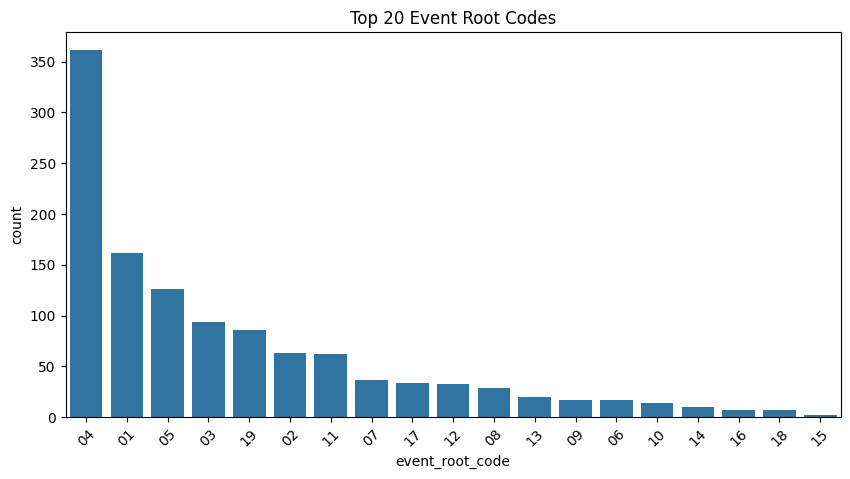

In [13]:
# ÏÇ¨Í±¥ ÏΩîÎìúÎ≥Ñ Î∂ÑÌè¨
event_dist = (
    final_silver_df.groupBy("event_root_code")
      .count()
      .orderBy(F.desc("count"))
      .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(x="event_root_code", y="count", data=event_dist.head(20))
plt.title("Top 20 Event Root Codes")
plt.xticks(rotation=45)
plt.show()

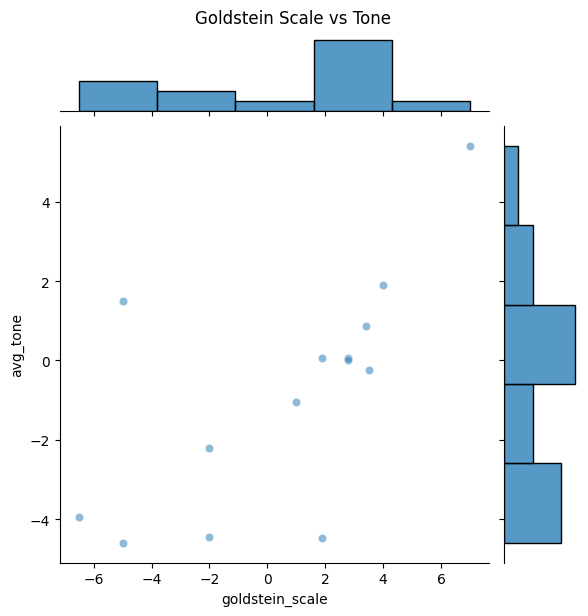

In [14]:
# Goldstein Scale & Tone Î∂ÑÌè¨
meta_pd = final_silver_df.select("goldstein_scale", "avg_tone").sample(False, 0.01).toPandas()
sns.jointplot(x="goldstein_scale", y="avg_tone", data=meta_pd, alpha=0.5)
plt.suptitle("Goldstein Scale vs Tone", y=1.02)
plt.show()

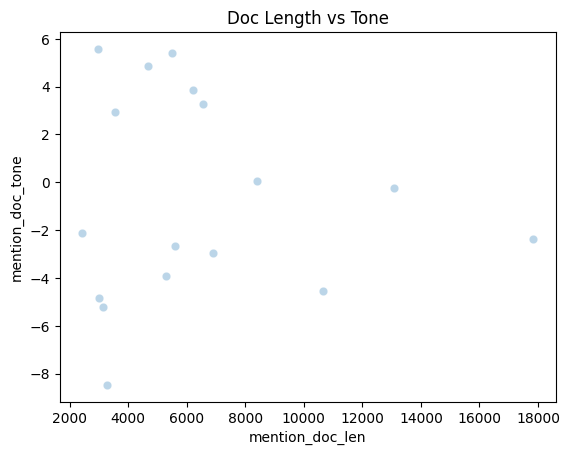

            mention_source_name  mention_doc_tone
13               thestar.com.my          5.580357
2             en.vietnamplus.vn          5.128854
1                  en.people.cn          3.875969
14                   vocalo.org          3.285968
0   communitynewspapergroup.com          2.922078
11             religionnews.com          0.072464
6                  links.org.au         -0.243546
12               thenews.com.pk         -2.391149
8              newstalkzb.co.nz         -2.392307
7              naija247news.com         -2.944269


In [15]:
# --------------------------------------------------
# 3. Mention Î©îÌÉÄÎç∞Ïù¥ÌÑ∞ EDA
# --------------------------------------------------
mention_pd = (
    final_silver_df.select("mention_source_name", "mention_doc_len", "mention_doc_tone", "confidence")
      .sample(False, 0.01)
      .toPandas()
)

# Í∏∞ÏÇ¨ Í∏∏Ïù¥ vs ÌÜ§
sns.scatterplot(x="mention_doc_len", y="mention_doc_tone", alpha=0.3, data=mention_pd)
plt.title("Doc Length vs Tone")
plt.show()

# ÏÜåÏä§Î≥Ñ ÌèâÍ∑† ÌÜ§
src_tone = (
    mention_pd.groupby("mention_source_name")["mention_doc_tone"]
    .mean()
    .reset_index()
    .sort_values("mention_doc_tone", ascending=False)
)
print(src_tone.head(10))

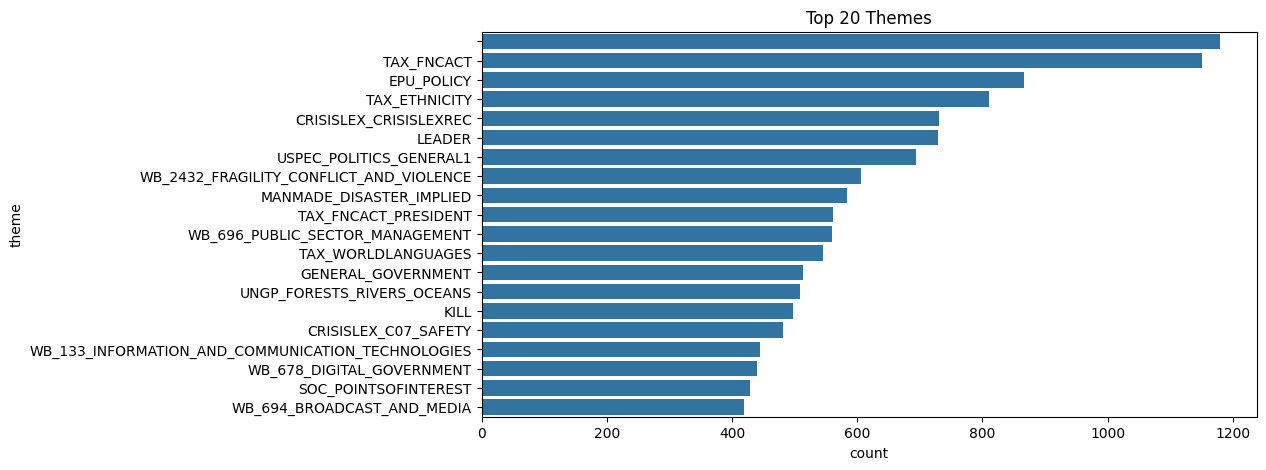

In [16]:
# --------------------------------------------------
# 4. GKG ÌÉúÍ∑∏ Î∂ÑÏÑù
# --------------------------------------------------
# Themes ÏÉÅÏúÑ ÎπàÎèÑ
themes = (
    final_silver_df.select(F.explode(F.split("themes", ";")).alias("theme"))
      .groupBy("theme").count()
      .orderBy(F.desc("count"))
      .limit(20)
      .toPandas()
)

plt.figure(figsize=(10,5))
sns.barplot(y="theme", x="count", data=themes)
plt.title("Top 20 Themes")
plt.show()

In [17]:
# Ïù∏Î¨º / Ï°∞ÏßÅ ÌÉúÍ∑∏ (persons, organizations)
persons = (
    final_silver_df.select(F.explode(F.split("persons", ";")).alias("person"))
      .groupBy("person").count()
      .orderBy(F.desc("count"))
      .limit(20)
      .toPandas()
)
print("Top Persons:\n", persons)

Top Persons:
                            person  count
0      Abdel Fattah El Sisi,14410     77
1               Donald Trump,4769     77
2          Masoud Pezeshkian,5127     77
3         Benjamin Netanyahu,4751     77
4            Shehbaz Sharif,12175     77
5                   Hamad Al,9711     77
6               Sheikh Tamim,9698     77
7   Marshal Syed Asim Munir,12471     77
8   Jasem Mohamed Al-Budaiwi,3803     77
9                Tayyip Erdo,6322     77
10   Mohammed Shia Al-Sudani,5174     77
11      Abdel Fattah El-Sisi,5540     77
12              Sheikh Tamim,6599     77
13            Tayyip Erdogan,5215     77
14              Sheikh Tamim,7640     77
15            Shehbaz Sharif,8362     77
16       Muhammad Ishaq Dar,12439     77
17                  Hamad Al,6612     77
18              Donald Trump,4492     77
19              Marco Rubio,15544     77


In [18]:
# --------------------------------------------------
# 5. Î©ÄÌã∞ÎØ∏ÎîîÏñ¥/ÏÜåÏÖú Î©îÌÉÄ
# --------------------------------------------------
media_stats = final_silver_df.select(
    F.count(F.when(F.col("sharing_image").isNotNull(), 1)).alias("image_count"),
    F.count(F.when(F.col("social_video_embeds").isNotNull(), 1)).alias("video_count")
).toPandas()

print(media_stats)

   image_count  video_count
0          196          460


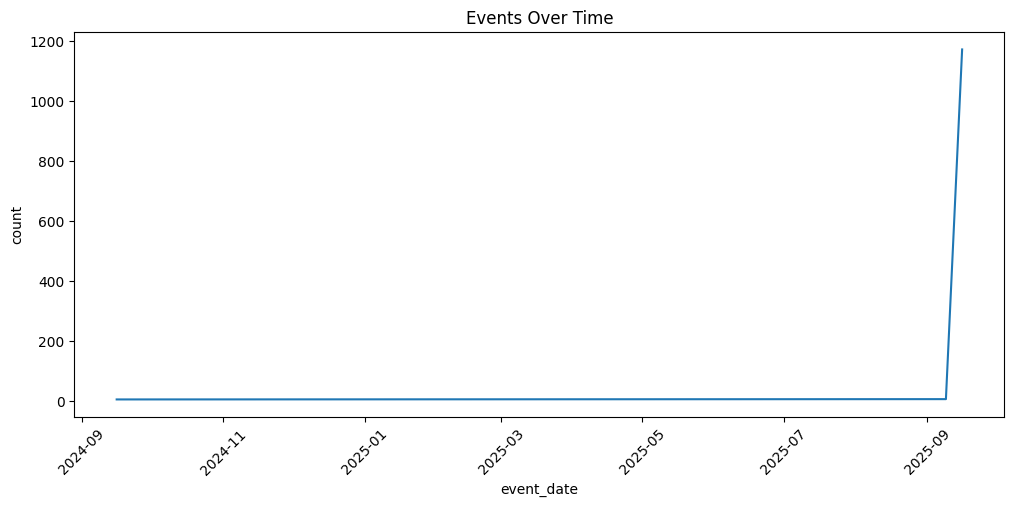

In [19]:
# --------------------------------------------------
# 6. ÏãúÍ≥ÑÏó¥ Î∂ÑÏÑù
# --------------------------------------------------
# ÏùºÏûêÎ≥Ñ Ïù¥Î≤§Ìä∏ Ïàò
time_series = (
    final_silver_df.groupBy("event_date")
      .count()
      .orderBy("event_date")
      .toPandas()
)

plt.figure(figsize=(12,5))
sns.lineplot(x="event_date", y="count", data=time_series)
plt.title("Events Over Time")
plt.xticks(rotation=45)
plt.show()

In [20]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType

# ‚úÖ CAMEO Event Code ‚Üí ÌïúÍµ≠Ïñ¥ ÏÑ§Î™Ö Îß§Ìïë
CAMEO_EVENT_MAP_KO = {
    "010": "Í≥µÏãù ÏÑ±Î™ÖÏùÑ Î∞úÌëúÌñàÎã§ (issued a public statement)",
    "020": "Í∏¥Í∏â Ìò∏ÏÜåÎ•º ÌñàÎã§ (made an urgent appeal)",
    "030": "ÌòëÎ†• ÏùòÏßÄÎ•º Í∞ïÎ†•Ìûà ÌëúÎ™ÖÌñàÎã§ (expressed strong intent to cooperate with)",
    "040": "ÌòëÏùòÎ•º Í∞ÄÏ°åÎã§ (held consultations with)",
    "050": "Ïô∏ÍµêÏ†Å ÌòëÎ†•ÏùÑ ÌñàÎã§ (engaged in diplomatic cooperation with)",
    "060": "Î¨ºÏßàÏ†Å ÏßÄÏõêÏùÑ Ï†úÍ≥µÌñàÎã§ (provided material cooperation to)",
    "070": "ÏõêÏ°∞Î•º ÌôïÎåÄÌñàÎã§ (extended aid to)",
    "080": "ÏöîÍµ¨Ïóê Íµ¥Î≥µÌñàÎã§ (yielded to demands from)",
    "090": "Ï°∞ÏÇ¨Î•º ÏãúÏûëÌñàÎã§ (launched an investigation into)",
    "100": "ÏöîÍµ¨ÏÇ¨Ìï≠ÏùÑ Ï†úÍ∏∞ÌñàÎã§ (made demands to)",
    "110": "Î∂àÎßåÏùÑ ÌëúÎ™ÖÌñàÎã§ (voiced disapproval of)",
    "120": "Ï†úÏïàÏùÑ Í±∞Î∂ÄÌñàÎã§ (rejected proposals from)",
    "130": "ÏúÑÌòëÏùÑ Í∞ÄÌñàÎã§ (issued threats against)",
    "140": "ÏãúÏúÑÎ•º Ï°∞ÏßÅÌñàÎã§ (organized protests against)",
    "150": "Íµ∞ÏÇ¨Î†•ÏùÑ ÏãúÏúÑÌñàÎã§ (demonstrated military force against)",
    "160": "Í¥ÄÍ≥ÑÎ•º Îã®Ï†àÌñàÎã§ (severed relations with)",
    "170": "Í∞ïÏïïÏùÑ Í∞ÄÌñàÎã§ (applied coercion to)",
    "180": "Í≥µÍ≤©ÏùÑ Í∞úÏãúÌñàÎã§ (launched assault on)",
    "190": "Î¨¥Î†• Ï∂©ÎèåÏùÑ Î≤åÏòÄÎã§ (engaged in armed conflict with)",
    "200": "ÎåÄÍ∑úÎ™® Ìè≠Î†•ÏùÑ ÏûêÌñâÌñàÎã§ (perpetrated mass violence against)",
}

# ‚úÖ Python Ìï®Ïàò Ï†ïÏùò (ÌïúÍµ≠Ïñ¥ Î≤ÑÏ†Ñ)
def summarize_event_udf(event_date, actor1, actor2, location, event_code, tone, goldstein, source):
    a1 = actor1 if actor1 else "Unknown Actor1"
    a2 = actor2 if actor2 else "Unknown Actor2"
    label = CAMEO_EVENT_MAP_KO.get(event_code, f"Event code {event_code}")
    loc = location if location else "Unknown location"
    src = source if source else "Unknown source"
    tone_str = f"{tone:.2f}" if tone is not None else "N/A"
    goldstein_str = f"{goldstein:.1f}" if goldstein is not None else "N/A"

    return f"{event_date}Ïóê {a1}Ïù¥(Í∞Ä) {a2}ÏôÄ Í¥ÄÎ†®ÌïòÏó¨ {loc}ÏóêÏÑú {label}. Í∏∞ÏÇ¨ Ï∂úÏ≤òÎäî {src}Ïù¥Î©∞, ÌèâÍ∑† ÌÜ§ÏùÄ {tone_str}, ÏÇ¨Í±¥ ÏòÅÌñ•ÎèÑ(Goldstein)Îäî {goldstein_str}Ïù¥Îã§."

# ‚úÖ PySpark UDF Îì±Î°ù
summarize_event = F.udf(summarize_event_udf, StringType())

# ‚úÖ ÏÉàÎ°úÏö¥ ÏöîÏïΩ Ïª¨Îüº Ï∂îÍ∞Ä
final_silver_df = final_silver_df.withColumn(
    "event_summary",
    summarize_event(
        F.col("event_date"),
        F.col("actor1_name"),
        F.col("actor2_name"),
        F.col("action_geo_fullname"),
        F.col("event_code"),
        F.col("avg_tone"),
        F.col("goldstein_scale"),
        F.col("mention_source_name")
    )
)

# ‚úÖ ÏÉòÌîå ÌôïÏù∏
final_silver_df.select("global_event_id", "event_summary").show(5, truncate=False)


+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|global_event_id|event_summary                                                                                                                                                                       |
+---------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1263346265     |2025-09-16Ïóê ARAB LEAGUEÏù¥(Í∞Ä) QATARÏôÄ Í¥ÄÎ†®ÌïòÏó¨ Doha, Ad Daw?ah, QatarÏóêÏÑú Event code 044. Í∏∞ÏÇ¨ Ï∂úÏ≤òÎäî en.people.cnÏù¥Î©∞, ÌèâÍ∑† ÌÜ§ÏùÄ -2.91, ÏÇ¨Í±¥ ÏòÅÌñ•ÎèÑ(Goldstein)Îäî 2.5Ïù¥Îã§.         |
|1263346264     |2025-09-16Ïóê ARAB LEAGUEÏù¥(Í∞Ä) QATARÏôÄ Í¥ÄÎ†®ÌïòÏó¨ Doha, Ad Daw?ah, QatarÏóêÏÑú Event code 044. Í∏∞ÏÇ¨ Ï∂úÏ≤òÎäî en.people.cnÏù¥Î©∞, ÌèâÍ∑† ÌÜ§ÏùÄ -2.91,

In [21]:
# --------------------------------------------------
# üìå GDELT Themes Îß§Ìïë & ÏöîÏïΩ Ï≤òÎ¶¨ ÏΩîÎìú
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from collections import Counter

# ‚úÖ 1. themes Ï†ëÎëêÏñ¥ Îß§Ìïë ÏÇ¨Ï†Ñ Ï†ïÏùò
theme_mapping = {
    "WB_": "ÏÑ∏Í≥ÑÏùÄÌñâ Ï£ºÏ†ú (World Bank theme)",
    "ECON_": "Í≤ΩÏ†ú (economic)",
    "TAX_": "ÏÑ∏Í∏à (taxation)",
    "TRADE": "Î¨¥Ïó≠ (trade)",
    "CRISISLEX_": "ÏúÑÍ∏∞ (crisis)",
    "NATURAL_DISASTER_": "ÏûêÏó∞Ïû¨Ìï¥ (natural disaster)",
    "FNCACT": "Í∏àÏúµ ÌôúÎèô (financial activities)",
    "EPU_": "Í≤ΩÏ†úÏ†ïÏ±Ö Î∂àÌôïÏã§ÏÑ± (economic policy uncertainty)",
    "SANCTIONS": "Ï†úÏû¨ (sanctions)",
    "AID_": "ÏõêÏ°∞/Ïù∏ÎèÑÏ£ºÏùò ÏßÄÏõê (aid/humanitarian)",
    "UNREST_": "ÏÇ¨Ìöå Î∂àÏïà/Ï†ÄÌï≠ (unrest)",
    "TERROR": "ÌÖåÎü¨ Í¥ÄÎ†® (terrorism)",
    "CONFLICT": "Î∂ÑÏüÅ/Í∞àÎì± (conflict)",
    "HUMAN_RIGHTS": "Ïù∏Í∂å (human rights)",
    "MEDIA": "ÎØ∏ÎîîÏñ¥/Ïñ∏Î°† (media)",
    "DISASTER": "Ïû¨Ìï¥ (disaster)"
    # ÌïÑÏöîÏãú Í≥ÑÏÜç ÌôïÏû•
}

# ‚úÖ 2. themes Î¨∏ÏûêÏó¥ÏùÑ ÏöîÏïΩÌïòÎäî Ìï®Ïàò
def summarize_themes(themes: str) -> str:
    if not themes:
        return ""
    counter = Counter()
    for t in themes.split(";"):
        matched = False
        for key, val in theme_mapping.items():
            if t.startswith(key):
                counter[val.strip()] += 1
                matched = True
                break
        if not matched:
            counter["Í∏∞ÌÉÄ"] += 1
    # ÏÉÅÏúÑ 5Í∞ú Ïπ¥ÌÖåÍ≥†Î¶¨Îßå ÏöîÏïΩ
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(5)])

# ‚úÖ 3. PySpark UDF Îì±Î°ù
summarize_themes_udf = F.udf(summarize_themes, StringType())

# ‚úÖ 4. ÏõêÎ≥∏ themes ‚Üí themes_summary Ï∂îÍ∞Ä
final_silver_df = final_silver_df.withColumn(
    "themes_summary", summarize_themes_udf(F.col("themes"))
)

# ‚úÖ 5. ÌôïÏù∏Ïö© Ï∂úÎ†•
final_silver_df.select("themes_summary", "themes").show(10, truncate=False)


+--------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [22]:
# --------------------------------------------------
# üìå GDELT Î¨∏Îß• ÌÉúÍ∑∏ Îß§Ìïë & ÏöîÏïΩ Ï≤òÎ¶¨ ÏΩîÎìú
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from collections import Counter

# ‚úÖ 1. themes Ï†ëÎëêÏñ¥ Îß§Ìïë ÏÇ¨Ï†Ñ Ï†ïÏùò
theme_mapping = {
    # Íµ≠Ï†úÍ∏∞Íµ¨/Ï†ïÏ±Ö Í¥ÄÎ†®
    "WB_": "ÏÑ∏Í≥ÑÏùÄÌñâ Ï£ºÏ†ú (World Bank theme)",
    "UN_": "Ïú†Ïóî Í¥ÄÎ†® (United Nations)",
    "EU_": "Ïú†ÎüΩÏó∞Ìï© Í¥ÄÎ†® (European Union)",

    # Í≤ΩÏ†ú/Ïû¨Ï†ï
    "ECON_": "Í≤ΩÏ†ú (economic)",
    "EPU_": "Í≤ΩÏ†úÏ†ïÏ±Ö Î∂àÌôïÏã§ÏÑ± (economic policy uncertainty)",
    "FINANCE": "Í∏àÏúµ/Ïû¨Ï†ï (finance)",
    "FNCACT": "Í∏àÏúµ ÌôúÎèô (financial activities)",
    "TAX_": "ÏÑ∏Í∏à (taxation)",
    "TRADE": "Î¨¥Ïó≠ (trade)",
    "INVEST": "Ìà¨Ïûê (investment)",
    "SANCTIONS": "Ï†úÏû¨ (sanctions)",

    # ÏÇ¨Ìöå/Ï†ïÏπò Î∂àÏïà
    "UNREST_": "ÏÇ¨Ìöå Î∂àÏïà/Ï†ÄÌï≠ (unrest)",
    "PROTEST": "ÏãúÏúÑ/Ìï≠Ïùò (protest)",
    "STRIKE": "ÌååÏóÖ/ÎÖ∏ÎèôÏüÅÏùò (strike)",
    "COUP": "Ïø†Îç∞ÌÉÄ (coup d'√©tat)",

    # Í∞àÎì±/ÏïàÎ≥¥
    "CONFLICT": "Î∂ÑÏüÅ/Í∞àÎì± (conflict)",
    "MILITARY": "Íµ∞ÏÇ¨ Í¥ÄÎ†® (military)",
    "SECURITY": "ÏïàÎ≥¥/Î∞©ÏúÑ (security)",
    "TERROR": "ÌÖåÎü¨ Í¥ÄÎ†® (terrorism)",
    "VIOLENCE": "Ìè≠Î†• ÏÇ¨Í±¥ (violence)",
    "WAR": "Ï†ÑÏüÅ (war)",

    # Ïù∏Í∂å/Î≤ïÏπò
    "HUMAN_RIGHTS": "Ïù∏Í∂å (human rights)",
    "GENOCIDE": "ÏßëÎã®ÌïôÏÇ¥ (genocide)",
    "JUSTICE": "ÏÇ¨Î≤ï/Ï†ïÏùò (justice)",
    "LAW": "Î≤ïÎ•†/Í∑úÏ†ú (law)",
    "SOVEREIGNTY": "Ï£ºÍ∂å Î¨∏Ï†ú (sovereignty)",

    # Ïû¨ÎÇú/ÏúÑÍ∏∞
    "CRISISLEX_": "ÏúÑÍ∏∞ (crisis)",
    "NATURAL_DISASTER_": "ÏûêÏó∞Ïû¨Ìï¥ (natural disaster)",
    "DISASTER": "Ïû¨Ìï¥ (disaster)",
    "FLOOD": "ÌôçÏàò (flood)",
    "EARTHQUAKE": "ÏßÄÏßÑ (earthquake)",
    "FIRE": "ÌôîÏû¨ (fire)",
    "EPIDEMIC": "Ï†ÑÏóºÎ≥ë/ÏßàÎ≥ë ÌôïÏÇ∞ (epidemic)",

    # ÏõêÏ°∞/Íµ¨Ìò∏
    "AID_": "ÏõêÏ°∞/Ïù∏ÎèÑÏ£ºÏùò ÏßÄÏõê (aid/humanitarian)",
    "FOOD_SECURITY": "ÏãùÎüâ ÏïàÎ≥¥ (food security)",
    "REFUGEE": "ÎÇúÎØº/Ïù¥Ï£ºÎØº (refugees/migration)",
    "HUMANITARIAN": "Ïù∏ÎèÑÏ£ºÏùò (humanitarian aid)",

    # ÌôòÍ≤Ω/ÏûêÏõê
    "CLIMATE": "Í∏∞ÌõÑ/ÌôòÍ≤Ω (climate/environment)",
    "ENERGY": "ÏóêÎÑàÏßÄ (energy)",
    "OIL": "ÏÑùÏú†/Í∞ÄÏä§ (oil/gas)",
    "WATER": "Î¨º ÏûêÏõê (water resources)",
    "FOREST": "ÏÇ∞Î¶º/ÏûêÏó∞ÏûêÏõê (forests/natural resources)",

    # ÎØ∏ÎîîÏñ¥/Ï†ïÎ≥¥
    "MEDIA": "ÎØ∏ÎîîÏñ¥/Ïñ∏Î°† (media)",
    "INTERNET": "Ïù∏ÌÑ∞ÎÑ∑/ÎîîÏßÄÌÑ∏ (internet/digital)",
    "ICT": "Ï†ïÎ≥¥ÌÜµÏã†Í∏∞Ïà† (ICT)",
    "SOCIAL_MEDIA": "ÏÜåÏÖú ÎØ∏ÎîîÏñ¥ (social media)",

    # Í∏∞ÌÉÄ
    "ELECTION": "ÏÑ†Í±∞/Ï†ïÏπò Í≥ºÏ†ï (elections)",
    "CORRUPTION": "Î∂ÄÌå® (corruption)",
    "TRANSPARENCY": "Ìà¨Î™ÖÏÑ± (transparency)",
    "CRIME": "Î≤îÏ£Ñ (crime)",
    "DRUG": "ÎßàÏïΩ/Î∂àÎ≤ïÍ±∞Îûò (drugs/illicit trade)",
    "ORGANIZED_CRIME": "Ï°∞ÏßÅÎ≤îÏ£Ñ (organized crime)",
}


# ‚úÖ 2. themes ÏöîÏïΩ Ìï®Ïàò
def summarize_themes(themes: str) -> str:
    if not themes:
        return ""
    counter = Counter()
    for t in themes.split(";"):
        matched = False
        for key, val in theme_mapping.items():
            if t.startswith(key):
                counter[val.strip()] += 1
                matched = True
                break
        if not matched:
            counter["Í∏∞ÌÉÄ"] += 1
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(5)])

# ‚úÖ 3. persons/orgs/locs ÏöîÏïΩ Ìï®Ïàò
def summarize_entities(tag_str: str, topn: int = 5) -> str:
    if not tag_str:
        return ""
    # GDELTÎäî "Ïù¥Î¶Ñ,ÎπàÎèÑ;Ïù¥Î¶Ñ,ÎπàÎèÑ;..." ÌòïÏãù
    entities = []
    for t in tag_str.split(";"):
        parts = t.split(",")
        if len(parts) >= 2:
            name, freq = parts[0].strip(), parts[1].strip()
            try:
                freq = int(freq)
            except:
                freq = 1
            entities.append((name, freq))
        else:
            entities.append((t.strip(), 1))
    counter = Counter(dict(entities))
    return ", ".join([f"{k}({v})" for k, v in counter.most_common(topn)])

# ‚úÖ 4. PySpark UDF Îì±Î°ù
summarize_themes_udf = F.udf(summarize_themes, StringType())
summarize_entities_udf = F.udf(summarize_entities, StringType())

# ‚úÖ 5. ÏÉàÎ°úÏö¥ Ïª¨Îüº ÏÉùÏÑ±
final_silver_df = (
    final_silver_df
    .withColumn("themes_summary", summarize_themes_udf(F.col("themes")))
    .withColumn("persons_summary", summarize_entities_udf(F.col("persons")))
    .withColumn("organizations_summary", summarize_entities_udf(F.col("organizations")))
    .withColumn("locations_summary", summarize_entities_udf(F.col("locations")))
)

# ‚úÖ 6. ÌôïÏù∏Ïö© Ï∂úÎ†•
final_silver_df.select(
    "themes_summary",
    "persons_summary",
    "organizations_summary",
    "locations_summary"
).show(10, truncate=False)


+----------------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|themes_summary                                                                                                                          |persons_summary                                                                         |organizations_summary                                                                                                                        |locations_summary                          

In [23]:
# --------------------------------------------------
# üìå GDELT Í∏∞ÏÇ¨ Îã®ÏúÑ Top Entities / Themes ÏßëÍ≥Ñ
# --------------------------------------------------

from pyspark.sql import functions as F

# ‚úÖ 1. Persons Top N ÏßëÍ≥Ñ
persons_exploded = (
    final_silver_df
    .withColumn("person", F.explode(F.split(F.col("persons"), ";")))
    .withColumn("person_name", F.split(F.col("person"), ",").getItem(0))
    .withColumn("person_freq", F.split(F.col("person"), ",").getItem(1).cast("int"))
    .filter(F.col("person_name").isNotNull())
)

top_persons = (
    persons_exploded.groupBy("person_name")
    .agg(F.sum("person_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ‚úÖ 2. Organizations Top N ÏßëÍ≥Ñ
orgs_exploded = (
    final_silver_df
    .withColumn("org", F.explode(F.split(F.col("organizations"), ";")))
    .withColumn("org_name", F.split(F.col("org"), ",").getItem(0))
    .withColumn("org_freq", F.split(F.col("org"), ",").getItem(1).cast("int"))
    .filter(F.col("org_name").isNotNull())
)

top_orgs = (
    orgs_exploded.groupBy("org_name")
    .agg(F.sum("org_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ‚úÖ 3. Locations Top N ÏßëÍ≥Ñ
locs_exploded = (
    final_silver_df
    .withColumn("loc", F.explode(F.split(F.col("locations"), ";")))
    .withColumn("loc_name", F.split(F.col("loc"), ",").getItem(0))
    .withColumn("loc_freq", F.split(F.col("loc"), ",").getItem(1).cast("int"))
    .filter(F.col("loc_name").isNotNull())
)

top_locs = (
    locs_exploded.groupBy("loc_name")
    .agg(F.sum("loc_freq").alias("total_mentions"))
    .orderBy(F.desc("total_mentions"))
)

# ‚úÖ 4. Themes Top N ÏßëÍ≥Ñ
themes_exploded = (
    final_silver_df
    .withColumn("theme", F.explode(F.split(F.col("themes"), ";")))
    .filter(F.col("theme").isNotNull())
)

top_themes = (
    themes_exploded.groupBy("theme")
    .count()
    .orderBy(F.desc("count"))
)

# ‚úÖ 5. ÌôïÏù∏ (ÏÉÅÏúÑ 10Í∞ú)
print("üî• Top Persons")
top_persons.show(10, truncate=False)

print("üî• Top Organizations")
top_orgs.show(10, truncate=False)

print("üî• Top Locations")
top_locs.show(10, truncate=False)

print("üî• Top Themes")
top_themes.show(10, truncate=False)


üî• Top Persons
+-----------------------+--------------+
|person_name            |total_mentions|
+-----------------------+--------------+
|Hamad Al               |2466630       |
|Sheikh Tamim           |2404864       |
|Abdulaziz Al Saud      |2065294       |
|Shehbaz Sharif         |1973202       |
|Donald Trump           |1345017       |
|Marco Rubio            |1214992       |
|Al Hussein             |1136828       |
|Abdel Fattah El Sisi   |1109570       |
|Ian Jo                 |1052068       |
|Marshal Syed Asim Munir|960267        |
+-----------------------+--------------+
only showing top 10 rows

üî• Top Organizations
+-------------------------------+--------------+
|org_name                       |total_mentions|
+-------------------------------+--------------+
|United States                  |3286382       |
|United Nations                 |3204195       |
|Green Alliance                 |1778146       |
|Great Commission               |1285260       |
|United Nations S

In [24]:
# --------------------------------------------------
# üìå ÎÇ†Ïßú(event_date)Î≥Ñ Top 5 Entities/ Themes Ï∂îÏù¥
# --------------------------------------------------

from pyspark.sql import functions as F
from pyspark.sql import Window

# ‚úÖ 1. Persons (ÎÇ†ÏßúÎ≥Ñ Top 5)
persons_exploded = (
    final_silver_df
    .withColumn("person", F.explode(F.split(F.col("persons"), ";")))
    .withColumn("person_name", F.split(F.col("person"), ",").getItem(0))
    .withColumn("person_freq", F.split(F.col("person"), ",").getItem(1).cast("int"))
    .filter(F.col("person_name").isNotNull())
)

persons_daily = (
    persons_exploded.groupBy("event_date", "person_name")
    .agg(F.sum("person_freq").alias("mentions"))
)

# ÎÇ†ÏßúÎ≥Ñ ÏàúÏúÑ Íµ¨ÌïòÍ∏∞
w = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_persons_daily = (
    persons_daily.withColumn("rank", F.rank().over(w))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ‚úÖ 2. Organizations (ÎÇ†ÏßúÎ≥Ñ Top 5)
orgs_exploded = (
    final_silver_df
    .withColumn("org", F.explode(F.split(F.col("organizations"), ";")))
    .withColumn("org_name", F.split(F.col("org"), ",").getItem(0))
    .withColumn("org_freq", F.split(F.col("org"), ",").getItem(1).cast("int"))
    .filter(F.col("org_name").isNotNull())
)

orgs_daily = (
    orgs_exploded.groupBy("event_date", "org_name")
    .agg(F.sum("org_freq").alias("mentions"))
)

w_org = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_orgs_daily = (
    orgs_daily.withColumn("rank", F.rank().over(w_org))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ‚úÖ 3. Locations (ÎÇ†ÏßúÎ≥Ñ Top 5)
locs_exploded = (
    final_silver_df
    .withColumn("loc", F.explode(F.split(F.col("locations"), ";")))
    .withColumn("loc_name", F.split(F.col("loc"), ",").getItem(0))
    .withColumn("loc_freq", F.split(F.col("loc"), ",").getItem(1).cast("int"))
    .filter(F.col("loc_name").isNotNull())
)

locs_daily = (
    locs_exploded.groupBy("event_date", "loc_name")
    .agg(F.sum("loc_freq").alias("mentions"))
)

w_loc = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_locs_daily = (
    locs_daily.withColumn("rank", F.rank().over(w_loc))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ‚úÖ 4. Themes (ÎÇ†ÏßúÎ≥Ñ Top 5)
themes_exploded = (
    final_silver_df
    .withColumn("theme", F.explode(F.split(F.col("themes"), ";")))
    .filter(F.col("theme").isNotNull())
)

themes_daily = (
    themes_exploded.groupBy("event_date", "theme")
    .count()
    .withColumnRenamed("count", "mentions")
)

w_theme = Window.partitionBy("event_date").orderBy(F.desc("mentions"))
top5_themes_daily = (
    themes_daily.withColumn("rank", F.rank().over(w_theme))
    .filter(F.col("rank") <= 5)
    .orderBy("event_date", "rank")
)

# ‚úÖ 5. ÌôïÏù∏ (ÏòàÏãú Ï∂úÎ†•)
print("üî• ÎÇ†ÏßúÎ≥Ñ Top 5 Ïù∏Î¨º")
top5_persons_daily.show(20, truncate=False)

print("üî• ÎÇ†ÏßúÎ≥Ñ Top 5 Ï°∞ÏßÅ")
top5_orgs_daily.show(20, truncate=False)

print("üî• ÎÇ†ÏßúÎ≥Ñ Top 5 ÏßÄÏó≠")
top5_locs_daily.show(20, truncate=False)

print("üî• ÎÇ†ÏßúÎ≥Ñ Top 5 Ï£ºÏ†ú")
top5_themes_daily.show(20, truncate=False)


üî• ÎÇ†ÏßúÎ≥Ñ Top 5 Ïù∏Î¨º
+----------+-----------------+--------+----+
|event_date|person_name      |mentions|rank|
+----------+-----------------+--------+----+
|2024-09-16|Liang Jun        |20644   |1   |
|2024-09-16|Zhang Kaiwei     |20596   |2   |
|2024-09-16|Radoslaw Sikorski|2724    |3   |
|2024-09-16|Wang Yi          |1840    |4   |
|2025-09-09|Ian Jo           |55372   |1   |
|2025-09-09|Ji Eun           |49942   |2   |
|2025-09-09|Hakyung Lee      |38524   |3   |
|2025-09-09|Ji-Eun Lee       |17900   |4   |
|2025-09-09|Ji Eun Lee       |16336   |5   |
|2025-09-16|Hamad Al         |2466630 |1   |
|2025-09-16|Sheikh Tamim     |2404864 |2   |
|2025-09-16|Abdulaziz Al Saud|2065294 |3   |
|2025-09-16|Shehbaz Sharif   |1973202 |4   |
|2025-09-16|Donald Trump     |1342320 |5   |
+----------+-----------------+--------+----+

üî• ÎÇ†ÏßúÎ≥Ñ Top 5 Ï°∞ÏßÅ
+----------+----------------------------------+--------+----+
|event_date|org_name                          |mentions|rank|
+--------

In [31]:
# 1. Í≤ΩÎ°ú Ï∂îÍ∞Ä (notebooks Ìè¥Îçî ÏïàÏóê detailed_story.pyÍ∞Ä ÏûàÏúºÎãàÍπå)
import sys
sys.path.append(r"/app/notebooks")

from detailed_story import (
    create_simple_story,
    create_rich_story,
    create_headline_story,
    create_event_summary,
    create_tone_story
)


print("‚úÖ Ïä§ÌÜ†Î¶¨ Ìï®Ïàò import ÏôÑÎ£å")

# 3. Spark DataFrameÏóêÏÑú ÎûúÎç§ ÏÉòÌîå ÎΩëÍ∏∞
random_sample = final_silver_df.orderBy(F.rand()).take(5)

# 4. Í∞Å Ïä§ÌÜ†Î¶¨ ÏÉùÏÑ± ÌÖåÏä§Ìä∏
for i, row in enumerate(random_sample, 1):
    row_dict = row.asDict()
    print(f"\n--- {i}Î≤àÏß∏ Ïù¥Î≤§Ìä∏ ({row_dict.get('event_date')}) ---")  # ÎÇ†Ïßú Í∞ôÏù¥ Ï∂úÎ†•
    print(f"Simple:   {create_simple_story(row_dict)}")
    print(f"Rich:     {create_rich_story(row_dict)}")
    print(f"Headline: {create_headline_story(row_dict)}")
    print(f"Summary:  {create_event_summary(row_dict)}")
    print(f"Tone:     {create_tone_story(row_dict)}")



‚úÖ Ïä§ÌÜ†Î¶¨ Ìï®Ïàò import ÏôÑÎ£å

--- 1Î≤àÏß∏ Ïù¥Î≤§Ìä∏ (2025-09-16) ---
Simple:   UNITED STATESÏù¥(Í∞Ä) Northeastern UniversityÏóêÏÑú Í≥µÏãù ÏÑ±Î™ÖÏùÑ Î∞úÌëúÌñàÎã§ (issued a public statement) (Ï§ëÎ¶ΩÏ†ÅÏúºÎ°ú (neutrally))
Rich:     Christian Broadcasting Network from UNITED STATESÏù¥(Í∞Ä) Northeastern UniversityÏóêÏÑú Ï§ëÎ¶ΩÏ†ÅÏù∏ ÌÜ§ÏúºÎ°ú (in a neutral tone) Í≥µÏãù ÏÑ±Î™ÖÏùÑ Î∞úÌëúÌñàÎã§ (issued a public statement) 0.0714285714285716,2.35714285714286,2.28571428571429,4.64285714285714,20.4285714285714,0.214285714285714,1265ÏôÄ Í¥ÄÎ†®ÌïòÏó¨ (involving 0.0714285714285716,2.35714285714286,2.28571428571429,4.64285714285714,20.4285714285714,0.214285714285714,1265) (2Í∞ú Í∏∞ÏÇ¨ÏóêÏÑú Î≥¥ÎèÑÎê®, religionnews.com Ìè¨Ìï® / reported across 2 articles including religionnews.com)
Headline: UNITED STATES issued statement
Summary:  Statement
Tone:     UNITED STATES issued statement (with a neutral tone)

--- 2Î≤àÏß∏ Ïù¥Î≤§Ìä∏ (2025-09-16) ---
Simple:   THE USÏù¥(Í∞Ä) United KingdomÏóêÏÑú CANADAÏ